In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import morphs

from pathlib2 import Path

import ephys
import ephys.clust
import ephys.viz

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from morphs.data.parse import blockpath_name

def recording_site(block_path):
    name = blockpath_name(block_path)
    axes = ['AP', 'ML', 'Z']
    idxs = zip(axes, [(0, -2),
                      (0, -1),
                      (1, -1)])
    vals = {}
    for axis, (i, j) in idxs:
        vals[axis] = name.split('__')[i].split('_')[j]
        assert vals[axis] [0:len(axis)] == axis
        vals[axis] = int(vals[axis][len(axis):])
    return tuple(vals[axis] for axis in axes)

In [3]:
# adapted from klustakwik
# NEVER POINT THIS AT SOMETHING YOU DONT TRUST
from six import exec_

def _read_python(path):
    assert path.exists()
    with open(path.as_posix(), 'r') as f:
        contents = f.read()
    metadata = {}
    exec_(contents, {}, metadata)
    metadata = {k.lower(): v for (k, v) in metadata.items()}
    return metadata

In [4]:
# try to find nice block used below, else use last one found
for block_path in morphs.paths.blocks():
    if 'Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3' in block_path:
        break
subj = morphs.data.parse.bird_id(block_path)
print recording_site(block_path)

(2500, 750, 2300)


Parse X,Y,Z pos of electrode tips for each of my recordings

In [5]:
for block in morphs.config.paths.blocks():
    print recording_site(block)

(2501, 500, 2222)
(2501, 500, 2410)
(2500, 750, 2300)
(2500, 750, 1880)
(2500, 750, 2000)
(2501, 500, 3072)
(2501, 500, 2050)
(2500, 160, 3368)
(2500, 160, 2950)
(2500, 160, 4323)
(2500, 160, 3368)
(2500, 160, 3721)
(2500, 160, 2337)
(2500, 160, 2583)
(2500, 500, 3100)
(2500, 500, 3200)
(2500, 120, 2650)
(2500, 120, 1950)
(2500, 120, 2377)
(2500, 120, 3000)
(2500, 1000, 2000)
(2500, 1100, 2000)
(2500, 1000, 2350)
(2500, 1000, 2207)
(2500, 50, 2500)
(2500, 50, 2850)
(2450, 100, 2500)
(2500, 50, 3400)
(2500, 100, 3000)
(2450, 100, 3000)
(2550, 100, 2500)
(2500, 100, 2500)
(2550, 100, 3000)
(2550, 100, 2720)
(2500, 150, 2100)
(2500, 150, 2915)
(2500, 150, 2500)
(2501, 150, 2400)
(2510, 200, 2250)
(2510, 200, 2000)
(2590, 200, 2000)
(2510, 200, 3000)
(2500, 200, 2250)
(2510, 200, 2700)
(2590, 200, 2250)
(2510, 200, 2450)
(2500, 500, 2500)
(2500, 500, 2250)
(2500, 500, 3000)
(2500, 500, 2750)
(2500, 500, 1500)


In [6]:
spikes = morphs.data.load.ephys_data(block_path, collapse_endpoints=True)

In [7]:
waveforms, cluster_map = ephys.clust.compute_cluster_waveforms_fast(block_path, spikes)

Example wavforms

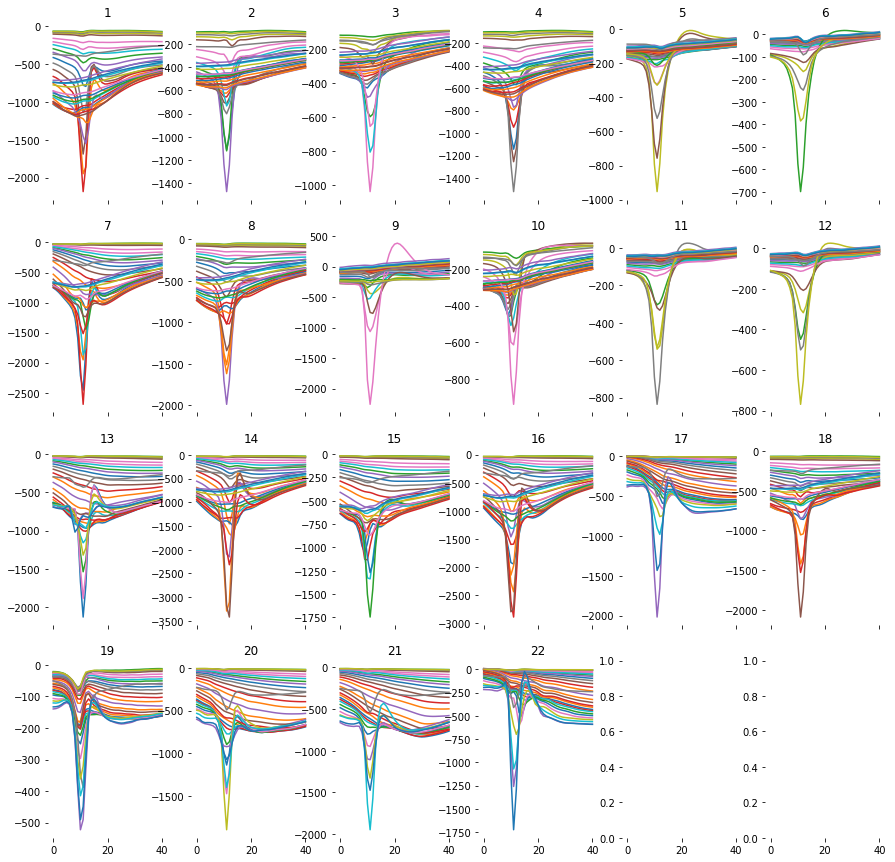

In [8]:
ephys.viz.plot_mean_cluster_waveforms(waveforms, cluster_map, sharey=False)

In [9]:
waveforms.shape
# cluster, t, channel

(22, 41, 31)

In [10]:
amps = (waveforms[:,0,:] + waveforms[:,-1,:]) / 2 - np.min(waveforms, axis=1)
amps /= np.max(amps, axis=0)
amps.shape

(22, 31)

In [11]:
clust = 2
clust_wavform = waveforms[clust,:,:]
clust_wavform.shape

(41, 31)

In [12]:
clust_amp = amps[clust,:]

amplitudes for each channel for a single cluster

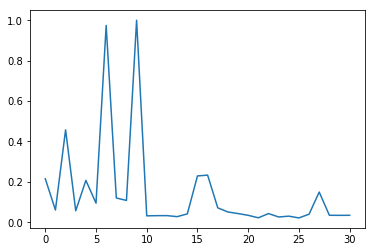

In [13]:
l = plt.plot(clust_amp)

Sorted amplitudes for a single cluster.

Should I set some amount of them to zero?

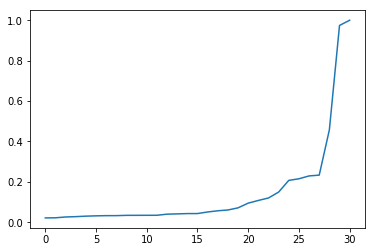

In [14]:
l = plt.plot(np.sort(clust_amp))

sorted amplitudes for all clusters at this site

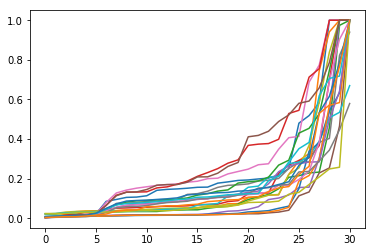

In [15]:
lines = plt.plot(np.sort(amps, axis=1).T)

Squaring the amplitude does a pretty effective job at zeroing out low values

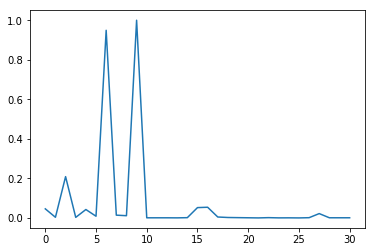

In [16]:
l = plt.plot(clust_amp ** 2)

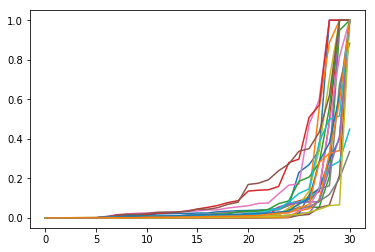

In [17]:
lines = plt.plot(np.sort(amps ** 2, axis=1).T)

and here's exp, which is related to the softmax

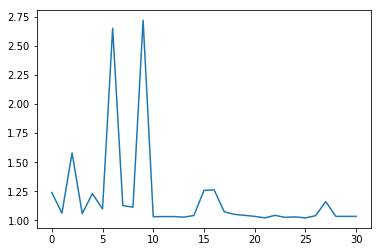

In [18]:
l = plt.plot(np.exp(clust_amp))

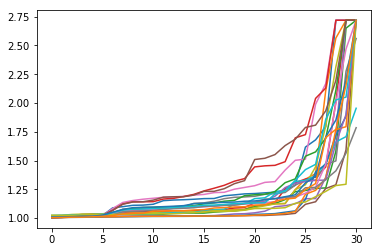

In [19]:
lines = plt.plot(np.sort(np.exp(amps), axis=1).T)

Lets look at where some of these clusters are weighted...

In [20]:
prb = _read_python(list(Path(block_path).glob('*.prb'))[0])
for group in prb['channel_groups']:
    chans = prb['channel_groups'][group]['geometry'].keys()
    x, y = zip(*[prb['channel_groups'][group]['geometry'][k] for k in chans])
idxs = np.argsort(y)
y = np.array(y)[idxs]

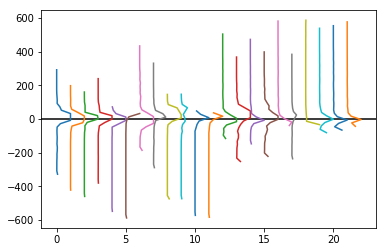

In [21]:
plt.axhline(0, color='k')
for clust in xrange(amps.shape[0]):
    temp = amps[clust,idxs] ** 2
    y_hat = np.sum(temp * y) / np.sum(temp)
    l = plt.plot(temp + clust, y - y_hat)

And one for each different probe I have...

In [22]:
prb_blocks = {}
for block in morphs.config.paths.blocks():
    prb_files = list(Path(block).glob('*.prb'))
    assert len(prb_files) == 1
    prb_name = prb_files[0].stem.lower()
    if not prb_name in prb_blocks:
        prb_blocks[prb_name] = []
    prb_blocks[prb_name].append(block)

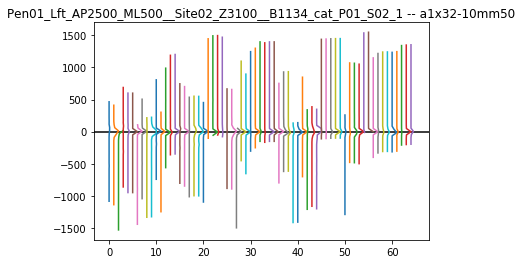

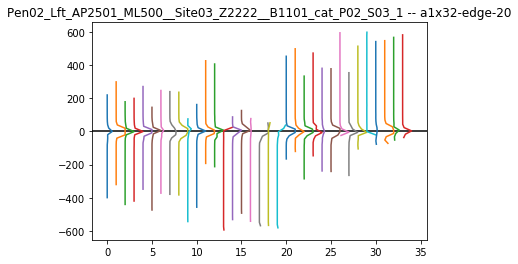

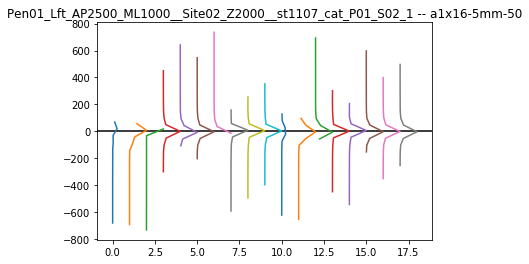

In [23]:
for probe in prb_blocks:
    for block in prb_blocks[probe]:
        spikes = morphs.data.load.ephys_data(block, collapse_endpoints=True)
        if len(spikes) == 0:
            continue
        waveforms, cluster_map = ephys.clust.compute_cluster_waveforms_fast(block, spikes)
        amps = (waveforms[:,0,:] + waveforms[:,-1,:]) / 2 - np.min(waveforms, axis=1)
        amps /= np.max(amps, axis=0)

        prb_files = list(Path(block).glob('*.prb'))
        assert len(prb_files) == 1
        prb = _read_python(prb_files[0])
        for group in prb['channel_groups']:
            chans = prb['channel_groups'][group]['geometry'].keys()
            x, y = zip(*[prb['channel_groups'][group]['geometry'][k] for k in chans])

            idxs = np.argsort(y)
            y = np.array(y)[idxs]
            plt.figure()
            plt.axhline(0, color='k')
            for clust in xrange(amps.shape[0]):
                temp = amps[clust,idxs] ** 2
                y_hat = np.sum(temp * y) / np.sum(temp)
                l = plt.plot(temp + clust, y - y_hat)
            plt.title(' -- '.join([morphs.data.parse.blockpath_name(block), probe]))
        break

and calculate all the y positions at once without sorting...

In [24]:
for group in prb['channel_groups']:
    chans = prb['channel_groups'][group]['geometry'].keys()
    x, y = zip(*[prb['channel_groups'][group]['geometry'][k] for k in chans])

In [25]:
temp = amps ** 2
y_hats = np.sum(temp * np.array(y).reshape((1,-1)), axis=1) / np.sum(temp, axis=1)

In [26]:
y_hats

array([681.13584243, 692.79926544, 732.73642097, 300.36242812,
       107.94831769, 203.23235495,  14.18010386, 592.1401738 ,
       494.95598308, 397.1201925 , 622.19453088, 654.18848962,
        56.75921064, 448.80114674, 543.98706863, 153.21489559,
       351.56522775, 253.67175891])